In [ ]:
python json2mask.py

loading annotations into memory...
Done (t=4.62s)
creating index...
index created!
No annotations found, producing an all-zero mask. Info: {'id': 7772, 'width': 2000, 'height': 1333, 'file_name': 'xulOLaCSKj.JPG', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0, 'timestamp': '2020:07:15 07:52:12', 'identity': 't522'}
Deleted image: /content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/test/xulOLaCSKj.JPG
No annotations found, producing an all-zero mask. Info: {'id': 8436, 'width': 2000, 'height': 1333, 'file_name': 'YFCPGMJkJg.jpeg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0, 'timestamp': '2020:07:10 18:32:08', 'identity': 't500'}
Deleted image: /content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/test/YFCPGMJkJg.jpeg


## DeepLabV3-ResNet101 的整体结构
```
输入图像：模型输入的图像。
特征提取：ResNet-101 作为主干网络提取图像的特征。
ASPP 模块：利用多尺度空洞卷积对特征进行多尺度处理，捕捉更多的上下文信息。
上采样：对经过 ASPP 处理后的特征图进行上采样，将其恢复到原始输入图像的分辨率。
语义分割输出：生成每个像素所属类别的预测，输出分割图。
```

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random


In [38]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None, fraction=1.0):
        """
        Initializes the SegmentationDataset.

        Parameters:
            images_dir (str): Path to the directory containing the images.
            masks_dir (str): Path to the directory containing the masks.
            transform (callable, optional): A function/transform to apply to the images.
            mask_transform (callable, optional): A function/transform to apply to the masks.
            fraction (float): The fraction of the dataset to use. Default is 1.0 (use the entire dataset).
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = os.listdir(images_dir)

        # If fraction is less than 1, sample a subset of the images
        if 0 < fraction < 1:
            subset_size = int(len(self.images) * fraction)
            self.images = random.sample(self.images, subset_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        image_extension = os.path.splitext(self.images[idx])[1]
        mask_name = os.path.join(self.masks_dir, self.images[idx].replace(image_extension, '.png'))
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask)
        return image, mask.squeeze(0)

In [30]:
# 数据预处理 和 数据增强 随机旋转、翻转、缩放和颜色抖动
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Nearest to keep class values intact
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Nearest to keep class values intact
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])

# 加载数据集
# 划分数据集为训练集和测试集

deeplavb3_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/' #save model

train_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/train/'
val_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/val/'
test_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/test/'

train_mask_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/masks/train/'
val_mask_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/masks/val/'
test_mask_path='/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/masks/test/'
train_dataset = SegmentationDataset(train_path, train_mask_path, transform=transform, mask_transform=mask_transform)
val_dataset = SegmentationDataset(val_path, val_mask_path, transform=transform, mask_transform=mask_transform)
test_dataset = SegmentationDataset(test_path, test_mask_path, transform=transform, mask_transform=mask_transform)
# test_dataset = SegmentationDataset('deeplabv3/test/', 'deeplabv3/masks/test1/', transform=transform, mask_transform=mask_transform)
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 加载 DeepLabV3 模型
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
num_classes = 4  # 根据您的类别数调整
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)  # 替换分类层
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # 使用 GPU 或 CPU



# 训练设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 改进了权重 更加重视代表性不足的类
weights = torch.tensor([0.5, 1.5, 2.5, 3.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
import random

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, is_train=True, fraction=1.0):
        """
        Initializes the SegmentationDataset.

        Parameters:
            images_dir (str): Path to the directory containing the images.
            masks_dir (str): Path to the directory containing the masks.
            is_train (bool): If True, apply data augmentation; if False, only basic preprocessing.
            fraction (float): The fraction of the dataset to use. Default is 1.0 (use the entire dataset).
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = os.listdir(images_dir)

        # Apply fraction if less than 1
        if 0 < fraction < 1:
            subset_size = int(len(self.images) * fraction)
            self.images = random.sample(self.images, subset_size)

        # Set up transforms
        self.transform, self.mask_transform = self.get_transforms(is_train)

    def get_transforms(self, is_train):
        """
        Get the transform and mask transform based on whether data augmentation is needed.

        Parameters:
            is_train (bool): Whether to apply data augmentation.

        Returns:
            (tuple): A tuple containing the image and mask transforms.
        """
        if is_train:
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])

        # Mask transform with nearest-neighbor interpolation
        mask_transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST),
            transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)),
        ])

        return transform, mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")

        # Extract file extension to find corresponding mask
        image_extension = os.path.splitext(self.images[idx])[1]
        mask_name = os.path.join(self.masks_dir, self.images[idx].replace(image_extension, '.png'))
        mask = Image.open(mask_name).convert("L")

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask.squeeze(0)


# Load and split datasets
deeplavb3_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/'

train_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/train/'
val_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/val/'
test_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/test/'

train_mask_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/masks/train/'
val_mask_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/masks/val/'
test_mask_path = '/content/drive/MyDrive/Colab_Notebooks/Deeplabv3_ljk/masks/test/'

train_dataset = SegmentationDataset(train_path, train_mask_path,is_train=True, fraction=0.5)
val_dataset = SegmentationDataset(val_path, val_mask_path, is_train=False, fraction=0.5)
test_dataset = SegmentationDataset(test_path, test_mask_path, is_train=False, fraction=0.5)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=16, pin_memory=True)  # Batch size increased
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=16,  pin_memory=True)

# Load and modify DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
num_classes = 4  # Adjust based on your number of classes
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

# Improved class weights to better handle class imbalance
# weights = torch.tensor([0.2, 1.0, 2.5, 4.0], dtype=torch.float32).to(device)  # Adjusted class weights
weights = torch.tensor([0.2, 1.0, 2.0, 2.5], dtype=torch.float32).to(device)  # Adjusted class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Use AdamW optimizer for better regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for dynamic adjustment
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Training loop
num_epochs = 15  # Increase epochs for better convergence
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        # Forward pass
        outputs = model(images)['out']

        loss = criterion(outputs, masks.long())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")
    # Scheduler step
    scheduler.step()

torch.save(model.state_dict(), f'{deeplavb3_path}deeplabv3_model1.pth')
print("Training complete.")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can 

Epoch [1/15], Loss: 1.3881
Epoch [1/15], Loss: 1.2550
Epoch [1/15], Loss: 1.1641
Epoch [1/15], Loss: 1.0663
Epoch [1/15], Loss: 0.9858
Epoch [1/15], Loss: 1.1450
Epoch [1/15], Loss: 1.0070
Epoch [1/15], Loss: 1.0237
Epoch [1/15], Loss: 0.8878
Epoch [1/15], Loss: 0.8845
Epoch [1/15], Loss: 0.8038
Epoch [1/15], Loss: 0.8509
Epoch [1/15], Loss: 1.1401
Epoch [1/15], Loss: 0.6693
Epoch [1/15], Loss: 0.7662
Epoch [1/15], Loss: 0.8050
Epoch [1/15], Loss: 0.6788
Epoch [1/15], Loss: 0.7348
Epoch [1/15], Loss: 0.7294
Epoch [1/15], Loss: 0.6831
Epoch [1/15], Loss: 0.7000
Epoch [1/15], Loss: 0.6888
Epoch [1/15], Loss: 0.5757
Epoch [1/15], Loss: 0.5694
Epoch [1/15], Loss: 0.6541
Epoch [1/15], Loss: 0.5885
Epoch [1/15], Loss: 0.5902
Epoch [1/15], Loss: 0.8106
Epoch [1/15], Loss: 0.6846
Epoch [1/15], Loss: 0.7884
Epoch [1/15], Loss: 0.6660
Epoch [1/15], Loss: 0.6168
Epoch [1/15], Loss: 0.6413
Epoch [1/15], Loss: 0.5916
Epoch [1/15], Loss: 0.5222
Epoch [1/15], Loss: 0.5571
Epoch [1/15], Loss: 0.6643
E

In [54]:
# 训练循环
num_epochs = 1  # 根据需要设置训练轮数
class_pixel_count = np.zeros(num_classes)  # Initialize class pixel count
for epoch in range(num_epochs):
    model.train()  # 训练模型
    for images, masks in train_loader:

        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        masks = masks.to('cuda' if torch.cuda.is_available() else 'cpu')

        for cls in range(num_classes):
            class_pixel_count[cls] += (masks == cls).sum().item()  # Count pixels for each class
            print(f"Batch pixel count for class {cls}: {(masks == cls).sum().item()}")
        # 清空梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(images)['out']

        # 计算损失
        loss = criterion(outputs, masks.long())  # 确保 mask 是 long 类型

        # 反向传播
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
torch.save(model.state_dict(), f'{deeplavb3_path}deeplabv3_model.pth')
print("Training complete. Model saved.")

Batch pixel count for class 0: 425321
Batch pixel count for class 1: 68708
Batch pixel count for class 2: 22548
Batch pixel count for class 3: 7711
Epoch [1/1], Loss: 0.7372
Batch pixel count for class 0: 429531
Batch pixel count for class 1: 76567
Batch pixel count for class 2: 11427
Batch pixel count for class 3: 6763
Epoch [1/1], Loss: 0.7914
Batch pixel count for class 0: 430749
Batch pixel count for class 1: 59530
Batch pixel count for class 2: 22244
Batch pixel count for class 3: 11765
Epoch [1/1], Loss: 0.7679
Batch pixel count for class 0: 479102
Batch pixel count for class 1: 30525
Batch pixel count for class 2: 9387
Batch pixel count for class 3: 5274
Epoch [1/1], Loss: 0.9475
Batch pixel count for class 0: 450999
Batch pixel count for class 1: 49460
Batch pixel count for class 2: 15711
Batch pixel count for class 3: 8118
Epoch [1/1], Loss: 0.5688
Batch pixel count for class 0: 473623
Batch pixel count for class 1: 30487
Batch pixel count for class 2: 12562
Batch pixel count 

KeyboardInterrupt: 

In [85]:
#载入训练好的模型
model = torchvision.models.segmentation.__dict__["deeplabv3_resnet101"](aux_loss=True, num_classes=4)
checkpoint = torch.load(f'{deeplavb3_path}deeplabv3_model1.pth', map_location="cpu")

model.load_state_dict({k: v for k, v in checkpoint.items() if 'aux_classifier' not in k}, strict=False)
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    model.to('cuda')
model.eval()

<ipython-input-85-27d2834150ac>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{deeplavb3_path}deeplabv3_model1.pth', map_location="cpu")


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [78]:
def calculate_metrics(predictions, masks, num_classes):
    metrics = {
        'iou': np.zeros(num_classes),
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
    }

    # Calculate IoU per class
    for cls in range(num_classes):
        pred_mask = (predictions == cls).astype(np.uint8)
        true_mask = (masks == cls).astype(np.uint8)

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        if union > 0:
            metrics['iou'][cls] = intersection / union  # IoU for each class

    metrics['confusion_matrix'] = confusion_matrix(masks.flatten(), predictions.flatten(), labels=range(num_classes))
    return metrics


In [79]:
# Set model to evaluation mode
def model_eval(model):
  model.eval()

  # Initialize arrays to store cumulative metrics across all images in the validation set
  all_metrics = {
      'iou': [],
      'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
  }

  # Evaluate model without computing gradients
  with torch.no_grad():
      for images, masks in val_loader:  # Assuming val_loader is your validation DataLoader
          device = 'cuda' if torch.cuda.is_available() else 'cpu'

          # Move images and masks to device
          images = images.to(device)
          masks = masks.to(device)

          # Forward pass to get predictions
          outputs = model(images)['out']
          predictions = outputs.argmax(dim=1).cpu().numpy()  # Convert predictions to numpy
          true_masks = masks.cpu().numpy()  # Convert ground truth to numpy

          # Calculate metrics for each image in the batch
          for pred, true_mask in zip(predictions, true_masks):
              metrics = calculate_metrics(pred, true_mask, num_classes)
              all_metrics['iou'].append(metrics['iou'])  # Append per-image IoU
              all_metrics['confusion_matrix'] += metrics['confusion_matrix']  # Add to cumulative confusion matrix

  # Aggregate IoU results across the dataset, excluding the background class (index 0)
  # Stack IoU results and exclude the first column (background) from mean calculation
  iou_array = np.vstack(all_metrics['iou'])
  mean_iou_per_class = np.nanmean(iou_array[:, 1:], axis=0)  # Exclude background class (index 0)
  overall_mean_iou = np.nanmean(mean_iou_per_class)  # Calculate mean IoU across non-background classes
  confusion_matrix_total = all_metrics['confusion_matrix']

  # Plot IoU per Class and Overall Mean IoU (excluding background)
  class_labels = ["Carapace", "Flippers", "Head"]
  plt.figure(figsize=(10, 5))
  plt.bar(class_labels + ["Mean IoU"], np.append(mean_iou_per_class, overall_mean_iou), color='lightblue')
  plt.ylim(0, 1)
  plt.ylabel("IoU")
  plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
  for i, v in enumerate(np.append(mean_iou_per_class, overall_mean_iou)):
      plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
  plt.show()

  # Plot Confusion Matrix
  # Include all classes in the confusion matrix but ignore background in IoU calculations
  all_class_labels = ["Background", "Carapace", "Flippers", "Head"]
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrix_total, annot=True, fmt="d", cmap="Blues", xticklabels=all_class_labels, yticklabels=all_class_labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.title("Confusion Matrix")
  plt.show()

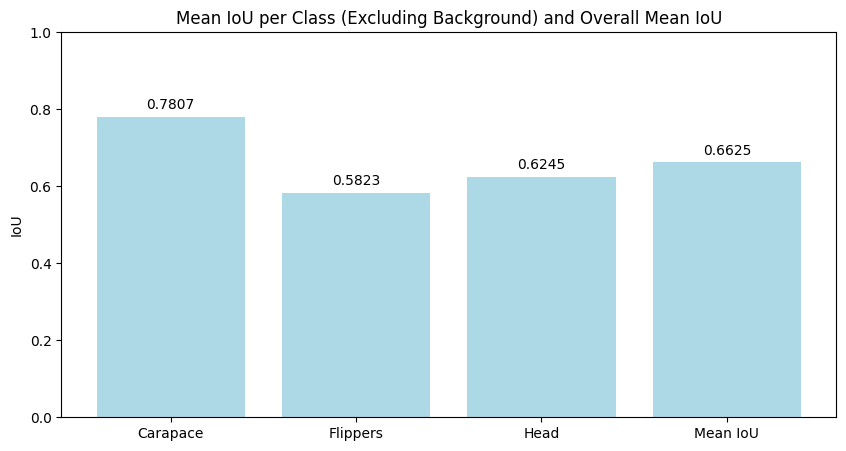

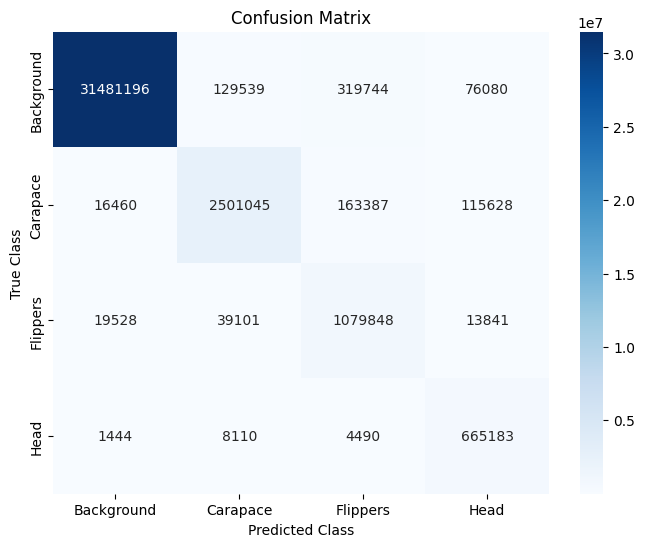

In [86]:
model_eval(model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


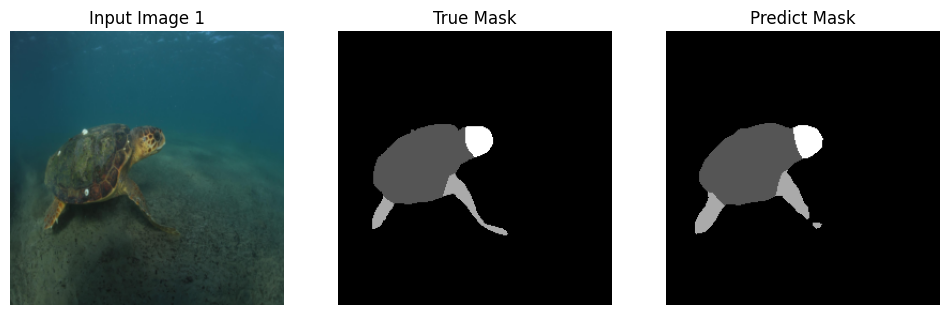

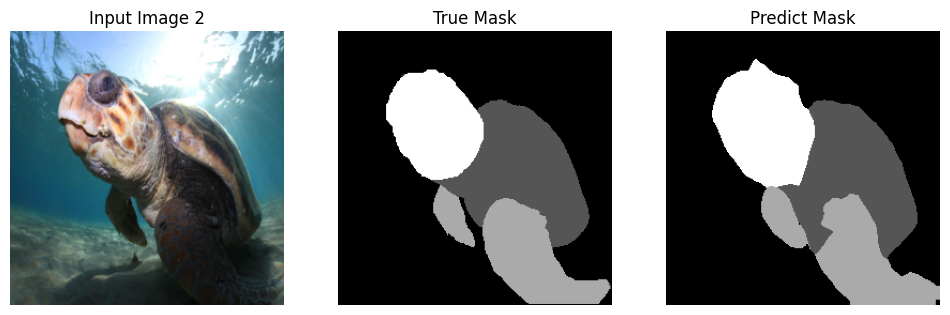

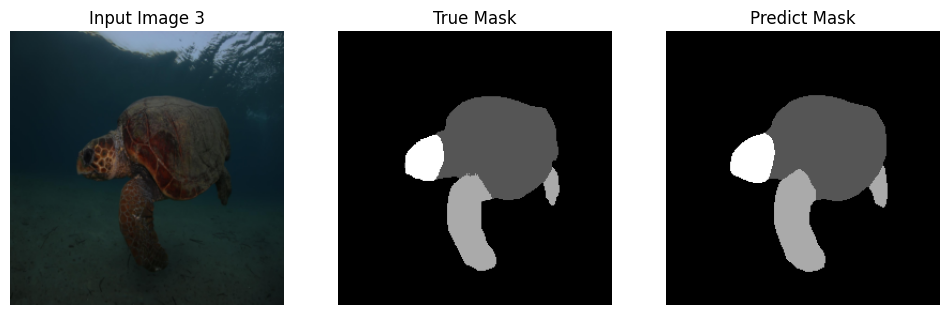

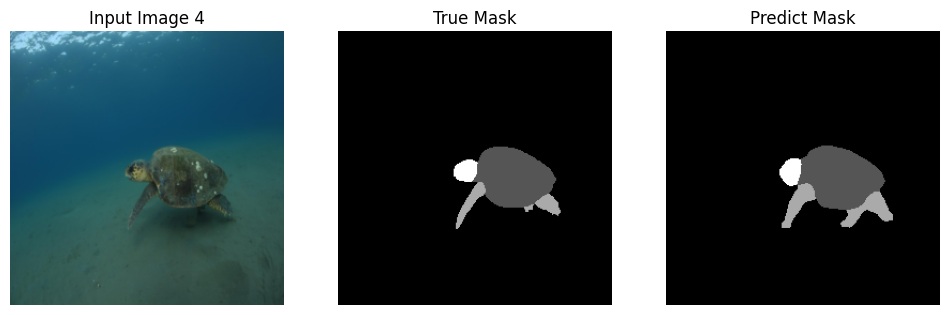

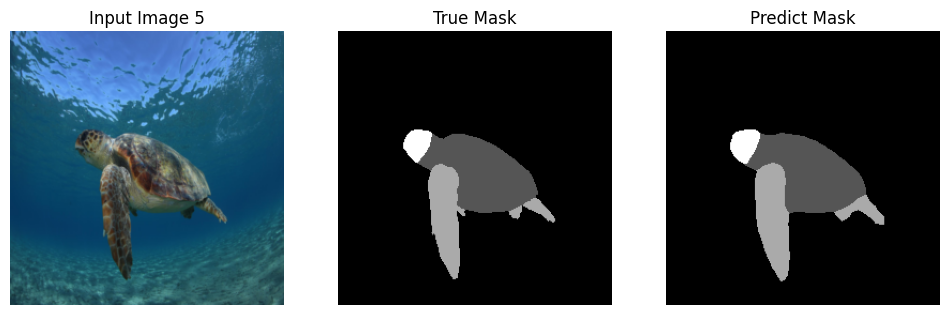

In [87]:
# def calculate_iou(prediction, mask, num_classes):
#     ious = []
#     for cls in range(num_classes):
#         pred_mask = (prediction == cls).astype(np.uint8)
#         true_mask = (mask == cls).astype(np.uint8)

#         intersection = np.logical_and(pred_mask, true_mask).sum()
#         union = np.logical_or(pred_mask, true_mask).sum()

#         if union == 0:
#             ious.append(np.nan)  # Ignore if there is no true or predicted pixels for this class
#         else:
#             ious.append(intersection / union)

#     return np.nanmean(ious)  # Mean IoU for the image

def visualize_top_iou_predictions(model, data_loader, num_classes, k=10):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    k_images = []
    # images_list = []
    # masks_list = []
    # predictions_list = []

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            outputs = model(images)['out']
            predictions = outputs.argmax(dim=1).cpu().numpy()
            masks = masks.cpu().numpy()

            # Calculate IoU for each image in the batch
            for i in range(images.size(0)):
                k_images.append((images[i].cpu(), masks[i], predictions[i]))


    k_images = k_images[:k]
    # Visualize the k images
    for idx, (image, mask, prediction) in enumerate(k_images, 1):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Input Image {idx}")
        plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predict Mask")
        plt.imshow(prediction, cmap='gray')
        plt.axis('off')

        plt.show()

# Visualize the top 10 images by IoU
visualize_top_iou_predictions(model, test_loader, num_classes, k=5)